**Introduction**

The Mean Teacher Model is a popular approach for semi-supervised learning, where a student model learns from a more stable teacher model that updates through Exponential Moving Average (EMA). It helps improve consistency between predictions and provides a smoother training signal.

Key Components of the Mean Teacher Model

**Student Model**: Learns from labeled and unlabeled data.

**Teacher Model**: A copy of the student that updates with EMA.

**Consistency Loss**: Encourages the student model to match the teacher’s predictions for unlabeled data.

**Exponential Moving Average (EMA) Update**:
Each parameter in the teacher model is updated using a weighted average of its previous values and the corresponding parameters in the student model:

In [1]:
!pip install "deeplake<4"

!pip install numpy==1.26.4


In [2]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

# !python -Xfrozen_modules=off your_script.py
!free -h


               total        used        free      shared  buff/cache   available
Mem:            52Gi       1.2Gi        44Gi        12Mi       7.0Gi        51Gi
Swap:             0B          0B          0B


**Imports**

In [3]:
import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

import deeplake
from PIL import Image

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset
from torchvision import models

import copy
import random

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.manifold import TSNE

/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.7) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

**Data Processing**

In [5]:
ds_train = deeplake.load("hub://activeloop/pacs-train")

-

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train



\

hub://activeloop/pacs-train loaded successfully.



In [6]:
ds_val = deeplake.load("hub://activeloop/pacs-val")

/

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-val



\

hub://activeloop/pacs-val loaded successfully.



In [7]:
domain_mapping = {


    "art_painting": 0,
    "cartoon": 1,
    "photo": 2,
    "sketch": 3
}

def filter_by_domain(ds, domain_name):
    domain_array = ds.domains.numpy()

    # Convert domain name to numerical label
    domain_label = domain_mapping.get(domain_name)
    if domain_label is None:
        raise ValueError(f"Invalid domain name: {domain_name}. Must be one of {list(domain_mapping.keys())}")

    # Get indices where domain matches
    indices = np.where(domain_array == domain_label)[0].tolist()

    if not indices:
        raise ValueError(f"No samples found for domain '{domain_name}'")

    # Properly filter the tensors
    return {
        "images": ds.images[indices].numpy(),
        "labels": ds.labels[indices].numpy(),
        "domains": ds.domains[indices].numpy()
    }



In [8]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ])


pacs_transform = transforms.Compose([
    transforms.Resize((224, 224)),  #  Standardize input size across domains

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])


sketch_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Helps orientation variations
    transforms.RandomRotation(10),  # Preserves line structure but adds some variation
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Avoids excessive deformation
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Mimics real-world sketch inconsistencies
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])


cartoon_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [9]:
class PACSDataset(Dataset):
    def __init__(self, data, transform=None):
        self.images = data["images"]
        self.labels = data["labels"]
        self.transform = transform  #  Store transform function

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self.images[idx]
        y = self.labels[idx]

        # ✅ Convert NumPy array to PIL Image before applying transforms
        x = Image.fromarray(x.astype('uint8'))

        if self.transform:
            x = self.transform(x)  #  Apply transformation

        return x, y


The **PACS dataset** is widely used for domain generalization in computer vision. It consists of four domains

Each domain contains seven categories: Dog, Elephant, Giraffe, Guitar, Horse, and Person2. The dataset is designed to test how well models generalize across different visual styles.

In [10]:
# Define transformation mappings for each domain
domain_transforms = {
    "cartoon": cartoon_transform,
    "sketch": sketch_transform,
    "photo": pacs_transform,  # Keep standard for photo
    "art_painting": pacs_transform,  # Keep standard for paintings
}

In [11]:
batch_size = 32


# Create dataloaders for training
dataloaders_train = {
    domain: DataLoader(
        PACSDataset(filter_by_domain(ds_train, domain), transform=domain_transforms[domain]),
        batch_size=batch_size, shuffle=True, num_workers=3, drop_last=True
    )
    for domain in domain_mapping.keys()
}

# Create dataloaders for validation
dataloaders_val = {
    domain: DataLoader(
        PACSDataset(filter_by_domain(ds_val, domain), transform=domain_transforms[domain]),
        batch_size=batch_size, shuffle=True, num_workers=3, drop_last=True
    )
    for domain in domain_mapping.keys()
}

In [12]:
train_photo_dataloader = dataloaders_train["photo"]
train_art_dataloader = dataloaders_train["art_painting"]
train_cartoon_dataloader = dataloaders_train["cartoon"]
train_sketch_dataloader = dataloaders_train["sketch"]

val_photo = dataloaders_val["photo"]
val_art_painting = dataloaders_val["art_painting"]
val_cartoon = dataloaders_val["cartoon"]
val_sketch = dataloaders_val["sketch"]

In [13]:
len(train_photo_dataloader), len(train_art_dataloader), len(train_cartoon_dataloader), len(train_sketch_dataloader)

(46, 57, 65, 110)

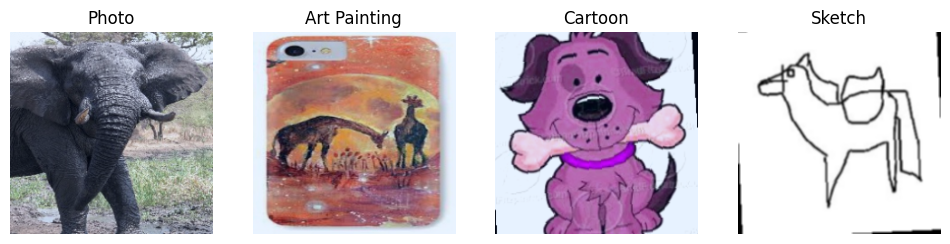

In [14]:
# Sample a batch from each dataloader
sample_photo, _ = next(iter(train_photo_dataloader))
sample_art, _ = next(iter(train_art_dataloader))
sample_cartoon, _ = next(iter(train_cartoon_dataloader))
sample_sketch, _ = next(iter(train_sketch_dataloader))

# Select one image per dataset
image_samples = [sample_photo[0], sample_art[0], sample_cartoon[0], sample_sketch[0]]
dataset_names = ["Photo", "Art Painting", "Cartoon", "Sketch"]

# Plot images with dataset names
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for i, ax in enumerate(axes):
    image = image_samples[i].cpu().permute(1, 2, 0)  # Convert tensor format for display
    image = image - image.min()  # Normalize pixel values
    image = image / image.max()

    ax.imshow(image)
    ax.set_title(dataset_names[i])
    ax.axis("off")

plt.show()

**Models**

In [94]:
num_classes = 7  # Modify for your task
student_model = models.resnet18(pretrained=True)


for param in student_model.parameters():
    param.requires_grad = True

for param in student_model.conv1.parameters():
    param.requires_grad = False

for param in student_model.bn1.parameters():
    param.requires_grad = False

for param in student_model.layer1.parameters():
    param.requires_grad = False

for param in student_model.layer2.parameters():
    param.requires_grad = False

# Modify the fully connected layer with Dropout
student_model.fc = nn.Sequential(
    nn.Linear(student_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),  # Dropout to prevent overfitting
    nn.Linear(512, num_classes)  # Final classification layer
)

teacher_model = models.resnet18(pretrained=True)
# Make teacher model match student's architecture
teacher_model.fc = nn.Sequential(
    nn.Linear(teacher_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
teacher_model.load_state_dict(student_model.state_dict())  # Start teacher as a copy of student
teacher_model.eval()  # Keep teacher frozen


student_model = student_model.to(device)
teacher_model = teacher_model.to(device)

In [95]:
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_grl):
        ctx.lambda_grl = lambda_grl
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_grl, None

class GradientReversalLayer(nn.Module):
    def __init__(self, lambda_grl=1.0):
        super(GradientReversalLayer, self).__init__()
        self.lambda_grl = lambda_grl

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_grl)

class DomainClassifier(nn.Module):
    def __init__(self, feature_dim=512, hidden_dim=128):
        super(DomainClassifier, self).__init__()
        self.fc1 = nn.Linear(feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.sigmoid(self.fc2(x))


In [96]:

def gaussian_kernel(x, y, sigma=None):
    dist = torch.cdist(x, y, p=2)  # Compute Euclidean distance

    # Adaptive bandwidth based on median absolute deviation (MAD)
    if sigma is None:
        sigma = torch.median(dist).item() / 1.4826  # Robust estimation

    # Prevent extremely small sigma values
    sigma = max(sigma, 0.1)

    # Clamp exponent range for numerical stability
    return torch.exp(-torch.clamp(dist**2 / (2 * sigma**2), min=0, max=50))


# MMD Loss Function
def mmd_loss(features_src, features_tgt):
    # Flatten features if necessary
    features_src = features_src.view(features_src.size(0), -1)
    features_tgt = features_tgt.view(features_tgt.size(0), -1)

    # Normalize features for numerical stability
    features_src = F.normalize(features_src, p=2, dim=1)
    features_tgt = F.normalize(features_tgt, p=2, dim=1)

    # Compute Kernel Matrices
    k_xx = gaussian_kernel(features_src, features_src)
    k_yy = gaussian_kernel(features_tgt, features_tgt)
    k_xy = gaussian_kernel(features_src, features_tgt)

    # Compute MMD Loss
    return k_xx.mean() + k_yy.mean() - 2 * k_xy.mean()

In [97]:
def extract_features(model, images):
    """Extracts intermediate features from ResNet before layer4."""
    with torch.no_grad():
        features = model.conv1(images)
        features = model.bn1(features)
        features = model.relu(features)
        features = model.maxpool(features)
        features = model.layer1(features)
        features = model.layer2(features)
        features = model.layer3(features)  # Ensure processed feature maps
        features = model.layer4(features)  # Now extract layer4 features

        # features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))  # Global pooling
        # features = features.view(features.size(0), -1)  # Flatten

    return features

In [98]:
criterion_sup = nn.CrossEntropyLoss(label_smoothing=0.1)  # For labeled data
criterion_unsup = nn.MSELoss()

domain_classifier = DomainClassifier(feature_dim=25088, hidden_dim=128).to(device)

student_optimizer = optim.Adam(student_model.parameters(), lr=0.00005, weight_decay=5e-4, amsgrad=True)  # Stabilized optimizer

**Training Loop**

In [111]:
# EMA update function
def update_teacher(student_model, teacher_model, alpha):
  for student_param, teacher_param in zip(student_model.parameters(), teacher_model.parameters()):
      teacher_param.data = alpha * teacher_param.data + (1 - alpha) * student_param.data

  # Print weight changes
  # print(f"Teacher param update: {torch.norm(teacher_param.data - student_param.data)}")


def train(student_model, teacher_model, dataloader_labeled, dataloader_unlabeled, domain_classifier,
          optimizer, lambda_unsup=0.001, alpha=0.3, lambda_mmd=1.0, lambda_dann=0.05, epochs=10):
    for epoch in range(epochs):
        student_model.train()
        teacher_model.eval()
        domain_classifier.train()

        for (labeled_batch, labels), (unlabeled_batch, _) in zip(dataloader_labeled, dataloader_unlabeled):
            labels = labels.to(device)
            labeled_batch, unlabeled_batch = labeled_batch.to(device), unlabeled_batch.to(device)

            # Forward pass
            student_preds_labeled = student_model(labeled_batch)
            student_preds_unlabeled = student_model(unlabeled_batch)

            teacher_preds_unlabeled = F.log_softmax(teacher_model(unlabeled_batch).detach(), dim=1)

            # Extract features for domain classification

            features_src = extract_features(student_model, labeled_batch)
            features_tgt = extract_features(student_model, unlabeled_batch)

            # Ensure features are correctly shaped for domain classifier
            features_src = features_src.view(features_src.shape[0], -1)
            features_tgt = features_tgt.view(features_tgt.shape[0], -1)

            # Compute MMD loss
            loss_mmd = mmd_loss(features_src, features_tgt)

            # Compute domain classification loss
            domain_labels_src = torch.ones(features_src.shape[0], 1).to(device)
            domain_labels_tgt = torch.zeros(features_tgt.shape[0], 1).to(device)

            domain_preds_src = domain_classifier(features_src)
            domain_preds_tgt = domain_classifier(features_tgt)

            loss_domain = F.binary_cross_entropy(domain_preds_src, domain_labels_src) + F.binary_cross_entropy(domain_preds_tgt, domain_labels_tgt)

            # Compute supervised and unsupervised losses
            labels = labels.long().squeeze()
            loss_sup = criterion_sup(student_preds_labeled, labels)
            student_preds_unlabeled = F.softmax(student_preds_unlabeled, dim=1)

            loss_unsup = lambda_unsup * criterion_unsup(student_preds_unlabeled, teacher_preds_unlabeled)  # Reintroduced lambda_unsup

            # Total loss
            total_loss = loss_sup + loss_unsup + lambda_mmd * loss_mmd + lambda_dann * loss_domain

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # EMA update for teacher model
            update_teacher(student_model, teacher_model, alpha)

        print(f"Epoch {epoch+1}: Supervised Loss={loss_sup.item():.4f}, Unsupervised Loss={loss_unsup.item():.4f}, Domain Loss={loss_domain.item():.4f}")

    return teacher_model, student_model


In [112]:
teacher_model_resnet, student_model_renset = train(student_model, teacher_model, train_sketch_dataloader, train_cartoon_dataloader, domain_classifier,  student_optimizer, epochs=10)

Epoch 1: Supervised Loss=0.4814, Unsupervised Loss=0.0096, Domain Loss=1.4051
Epoch 2: Supervised Loss=0.4852, Unsupervised Loss=0.0074, Domain Loss=1.3584
Epoch 3: Supervised Loss=0.5211, Unsupervised Loss=0.0071, Domain Loss=1.3781
Epoch 4: Supervised Loss=0.4689, Unsupervised Loss=0.0079, Domain Loss=1.4157
Epoch 5: Supervised Loss=0.5057, Unsupervised Loss=0.0077, Domain Loss=1.3789
Epoch 6: Supervised Loss=0.4770, Unsupervised Loss=0.0070, Domain Loss=1.3851
Epoch 7: Supervised Loss=0.4953, Unsupervised Loss=0.0073, Domain Loss=1.3895
Epoch 8: Supervised Loss=0.4827, Unsupervised Loss=0.0061, Domain Loss=1.3978
Epoch 9: Supervised Loss=0.4742, Unsupervised Loss=0.0064, Domain Loss=1.3708
Epoch 10: Supervised Loss=0.4655, Unsupervised Loss=0.0063, Domain Loss=1.3764


You're seeing consistent supervised learning with stable loss values, meaning your model is absorbing labeled data effectively. The unsupervised loss remains low, which is good—suggesting the student model is learning from the teacher without drastic divergence. The domain loss shows small fluctuations but stays within a reasonable range, indicating the domain alignment is holding up well.

In [113]:
def evaluate_model(model, dataloader_val, criterion_sup, device="cuda"):
    model.to(device)
    model.eval()  # Set to evaluation mode

    total_loss = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():  # No gradients needed for validation
        for val_batch, val_labels in dataloader_val:
            val_batch, val_labels = val_batch.to(device), val_labels.to(device).long().squeeze(dim=1)

            # Forward pass
            preds = model(val_batch)

            # Compute supervised loss
            loss = criterion_sup(preds, val_labels)
            total_loss += loss.item()

            # Compute accuracy
            predicted_classes = preds.argmax(dim=1)
            correct += (predicted_classes == val_labels).sum().item()
            total_samples += val_labels.size(0)

    avg_loss = total_loss / len(dataloader_val)
    accuracy = correct / total_samples

    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return avg_loss, accuracy

In [114]:
evaluate_model(student_model_renset, val_cartoon, nn.CrossEntropyLoss())

Validation Loss: 1.1839, Accuracy: 0.5938


(1.1839491639818465, 0.59375)

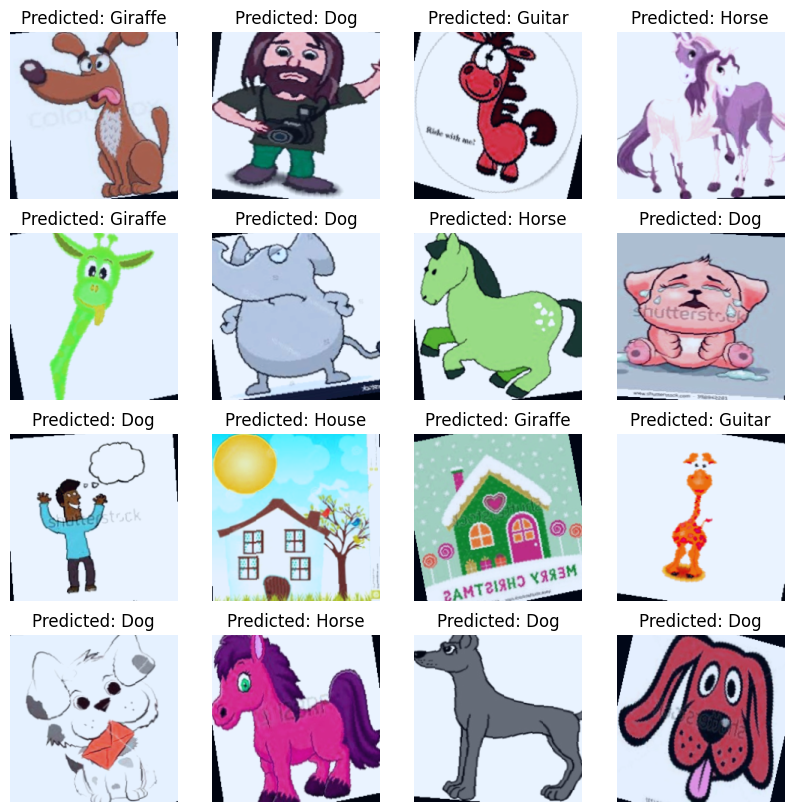

In [103]:
# Class Mapping for String Representations
class_labels = {
    0: "Dog", 1: "Elephant", 2: "Giraffe", 3: "Guitar",
    4: "Horse", 5: "House", 6: "Person"
}

# Visualization: Testing on Target Domain
def visualize_results(model, dataloader_target):
    model.eval()
    sample_images, _ = next(iter(dataloader_target))
    sample_images = sample_images.to(device)

    with torch.no_grad():
        predictions = model(sample_images)

    predicted_classes = predictions.argmax(dim=1).cpu().numpy()
    predicted_names = [class_labels[idx] for idx in predicted_classes]  # Convert indices to labels

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        image = sample_images[i].cpu()
        image = image - image.min()  # Normalize pixels
        image = image / image.max()

        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f"Predicted: {predicted_names[i]}")
        ax.axis("off")
    plt.show()

visualize_results(student_model_renset, val_cartoon)

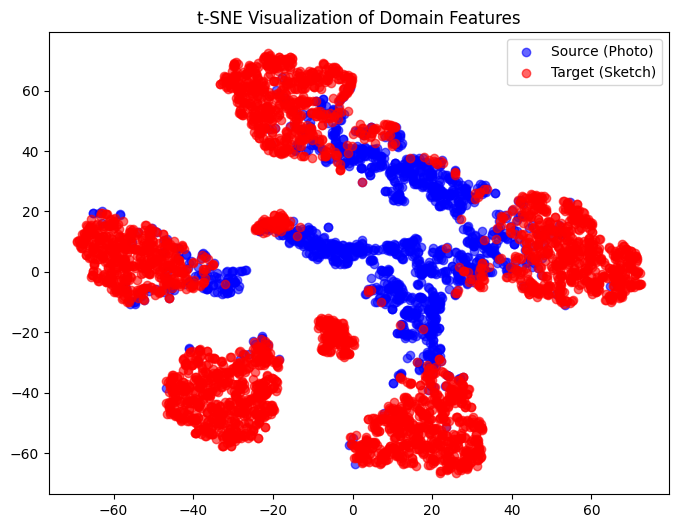

In [69]:
def extract_features_tsne(model, dataloader):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for images, target_labels in dataloader:
            images = images.to(device)
            feats = model(images)
            features.append(feats.cpu().numpy())
            labels.append(target_labels.numpy())

    return np.concatenate(features), np.concatenate(labels)


features_src, labels_src = extract_features_tsne(student_model_renset, dataloaders_train['photo'])
features_tgt, labels_tgt = extract_features_tsne(student_model_renset, dataloaders_train['sketch'])

# Combine features and labels
features = np.concatenate([features_src, features_tgt])
domains = np.concatenate([np.zeros(len(features_src)), np.ones(len(features_tgt))])  # 0 = Source, 1 = Target

# Apply t-SNE (or PCA instead)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot embeddings
plt.figure(figsize=(8, 6))
plt.scatter(features_2d[domains == 0, 0], features_2d[domains == 0, 1], label='Source (Photo)', alpha=0.6, color='blue')
plt.scatter(features_2d[domains == 1, 0], features_2d[domains == 1, 1], label='Target (Sketch)', alpha=0.6, color='red')
plt.legend()
plt.title("t-SNE Visualization of Domain Features")
plt.show()